In [64]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import torch
from torchvision import datasets, transforms

from torch import nn, optim
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from sklearn.manifold import TSNE

In [2]:
# seed 
seed = 17
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# set device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [4]:
# load MINST dataset, train + test as dataset


# define a transform to normalize the data
transform_ = transforms.Compose([transforms.ToTensor()])

# download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform_)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform_)

data = torch.utils.data.ConcatDataset([trainset, testset])

# make custum train, val and test sets from data in ratio 0.7, 0.1 and 0.2
train_size = int(0.7 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [5]:
# print size of train, val and test sets
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 49000
Validation set size: 7000
Test set size: 14000


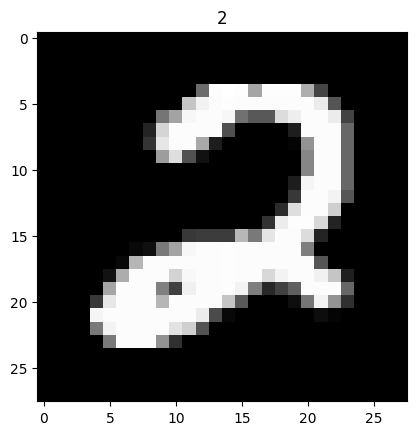

In [6]:
# visualize some images
dataiter = iter(train_loader)
for images, labels in dataiter:
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.title(str(labels[0].numpy()))
    plt.show()
    break

## ANN

In [7]:
# ANN model
class ANN(nn.Module):
    def __init__(self, input_size=784, output_size=10, hidden_layers=[120, 84]):
        super(ANN, self).__init__()
        for i, h in enumerate(hidden_layers):
            if i == 0:
                self.hidden = nn.ModuleList([nn.Linear(input_size, h)])
            else:
                self.hidden.append(nn.Linear(hidden_layers[i-1], h))
        self.output = nn.Linear(hidden_layers[-1], output_size)

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        x = F.log_softmax(self.output(x), dim=1)
        return x

In [39]:
# create model
config1 = {
    'input_size': 784,
    'output_size': 10,
    'hidden_layers': [300, 100]
}
config2 = {
    'input_size': 784,
    'output_size': 10,
    'hidden_layers': [256, 128, 64]
}
config3 = {
    'input_size': 784,
    'output_size': 10,
    'hidden_layers': [512, 256, 128, 64]
}
# print number of parameters for each configuration
model = ANN(**config1)
print(f"Number of parameters for config1: {sum(p.numel() for p in model.parameters())}")
model = ANN(**config2)
print(f"Number of parameters for config2: {sum(p.numel() for p in model.parameters())}")
model = ANN(**config3)
print(f"Number of parameters for config3: {sum(p.numel() for p in model.parameters())}")

Number of parameters for config1: 266610
Number of parameters for config2: 242762
Number of parameters for config3: 575050


In [9]:
def trainANN(model, train_loader, val_loader, optimizer, criterion, epochs=10, lr=0.001, output_dir='output'):

    # open log file
    log = open(f"{output_dir}/log.txt", "w")

    best_val_acc = 0

    # train the model
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            output = model(images.view(images.shape[0], -1))
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_losses.append(running_loss/len(train_loader))
        train_acc.append(correct/total)

        # validate the model
        model.eval()
        running_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images.view(images.shape[0], -1))
                loss = criterion(output, labels)
                running_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(running_loss/len(val_loader))
        val_acc.append(correct/total)

        # print epoch results
        print(f"Epoch {epoch+1}/{epochs} "
                  f"Train loss: {train_losses[-1]:.3f} "
                  f"Train accuracy: {train_acc[-1]:.3f} "
                  f"Validation loss: {val_losses[-1]:.3f} "
                  f"Validation accuracy: {val_acc[-1]:.3f}\n")
        
        # write to log file
        log.write(f"Epoch {epoch+1}/{epochs} "
                  f"Train loss: {train_losses[-1]:.3f} "
                  f"Train accuracy: {train_acc[-1]:.3f} "
                  f"Validation loss: {val_losses[-1]:.3f} "
                  f"Validation accuracy: {val_acc[-1]:.3f}\n")
        
        if (val_acc[-1] > best_val_acc):
            best_val_acc = val_acc[-1]
            torch.save(model.state_dict(), f"{output_dir}/best_model.pth")

    # save the last model
    torch.save(model.state_dict(), f"{output_dir}/last_model.pth")

    # close log file
    log.close()

In [10]:
def testANN(model, test_loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            output = model(images.view(images.shape[0], -1))
            loss = criterion(output, labels)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test loss: {running_loss/len(test_loader):.3f} "
              f"Test accuracy: {correct/total:.3f}\n")

In [11]:
def trainANN_config(config, config_num=1):
    model = ANN(**config).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    output_dir = os.getcwd()
    # print(f"Output directory: {output_dir}")
    output_dir = f"{output_dir}/ANNconfig{config_num}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    trainANN(model, train_loader, val_loader, optimizer, criterion, epochs=10, lr=0.001, output_dir=output_dir)

    model.load_state_dict(torch.load(f"{output_dir}/best_model.pth"))
    testANN(model, test_loader, criterion)


In [12]:
trainANN_config(config1, 1)
trainANN_config(config2, 2)
trainANN_config(config3, 3)

 10%|█         | 1/10 [00:04<00:44,  4.90s/it]

Epoch 1/10 Train loss: 0.310 Train accuracy: 0.912 Validation loss: 0.149 Validation accuracy: 0.955



 20%|██        | 2/10 [00:09<00:38,  4.78s/it]

Epoch 2/10 Train loss: 0.120 Train accuracy: 0.964 Validation loss: 0.102 Validation accuracy: 0.969



 30%|███       | 3/10 [00:14<00:33,  4.72s/it]

Epoch 3/10 Train loss: 0.078 Train accuracy: 0.976 Validation loss: 0.090 Validation accuracy: 0.972



 40%|████      | 4/10 [00:18<00:28,  4.67s/it]

Epoch 4/10 Train loss: 0.057 Train accuracy: 0.982 Validation loss: 0.093 Validation accuracy: 0.973



 50%|█████     | 5/10 [00:23<00:23,  4.66s/it]

Epoch 5/10 Train loss: 0.042 Train accuracy: 0.986 Validation loss: 0.084 Validation accuracy: 0.976



 60%|██████    | 6/10 [00:28<00:18,  4.65s/it]

Epoch 6/10 Train loss: 0.033 Train accuracy: 0.990 Validation loss: 0.082 Validation accuracy: 0.977



 70%|███████   | 7/10 [00:32<00:13,  4.60s/it]

Epoch 7/10 Train loss: 0.025 Train accuracy: 0.992 Validation loss: 0.082 Validation accuracy: 0.977



 80%|████████  | 8/10 [00:37<00:09,  4.57s/it]

Epoch 8/10 Train loss: 0.023 Train accuracy: 0.993 Validation loss: 0.078 Validation accuracy: 0.979



 90%|█████████ | 9/10 [00:41<00:04,  4.58s/it]

Epoch 9/10 Train loss: 0.019 Train accuracy: 0.993 Validation loss: 0.082 Validation accuracy: 0.978



100%|██████████| 10/10 [00:46<00:00,  4.63s/it]
/tmp/ipykernel_242915/378347071.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{outp

Epoch 10/10 Train loss: 0.016 Train accuracy: 0.995 Validation loss: 0.084 Validation accuracy: 0.979



100%|██████████| 219/219 [00:00<00:00, 225.55it/s]


Test loss: 0.097 Test accuracy: 0.975



 10%|█         | 1/10 [00:04<00:42,  4.70s/it]

Epoch 1/10 Train loss: 0.341 Train accuracy: 0.899 Validation loss: 0.152 Validation accuracy: 0.954



 20%|██        | 2/10 [00:09<00:37,  4.69s/it]

Epoch 2/10 Train loss: 0.124 Train accuracy: 0.962 Validation loss: 0.128 Validation accuracy: 0.963



 30%|███       | 3/10 [00:14<00:32,  4.71s/it]

Epoch 3/10 Train loss: 0.083 Train accuracy: 0.974 Validation loss: 0.081 Validation accuracy: 0.977



 40%|████      | 4/10 [00:18<00:28,  4.69s/it]

Epoch 4/10 Train loss: 0.061 Train accuracy: 0.980 Validation loss: 0.089 Validation accuracy: 0.974



 50%|█████     | 5/10 [00:23<00:23,  4.66s/it]

Epoch 5/10 Train loss: 0.047 Train accuracy: 0.985 Validation loss: 0.084 Validation accuracy: 0.975



 60%|██████    | 6/10 [00:28<00:18,  4.67s/it]

Epoch 6/10 Train loss: 0.037 Train accuracy: 0.988 Validation loss: 0.078 Validation accuracy: 0.977



 70%|███████   | 7/10 [00:32<00:13,  4.63s/it]

Epoch 7/10 Train loss: 0.031 Train accuracy: 0.990 Validation loss: 0.091 Validation accuracy: 0.977



 80%|████████  | 8/10 [00:37<00:09,  4.65s/it]

Epoch 8/10 Train loss: 0.026 Train accuracy: 0.991 Validation loss: 0.078 Validation accuracy: 0.978



 90%|█████████ | 9/10 [00:41<00:04,  4.65s/it]

Epoch 9/10 Train loss: 0.021 Train accuracy: 0.993 Validation loss: 0.096 Validation accuracy: 0.977



100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


Epoch 10/10 Train loss: 0.021 Train accuracy: 0.993 Validation loss: 0.094 Validation accuracy: 0.976



100%|██████████| 219/219 [00:00<00:00, 223.21it/s]


Test loss: 0.098 Test accuracy: 0.974



 10%|█         | 1/10 [00:04<00:43,  4.81s/it]

Epoch 1/10 Train loss: 0.336 Train accuracy: 0.899 Validation loss: 0.146 Validation accuracy: 0.958



 20%|██        | 2/10 [00:09<00:38,  4.77s/it]

Epoch 2/10 Train loss: 0.118 Train accuracy: 0.964 Validation loss: 0.105 Validation accuracy: 0.970



 30%|███       | 3/10 [00:14<00:33,  4.82s/it]

Epoch 3/10 Train loss: 0.075 Train accuracy: 0.977 Validation loss: 0.092 Validation accuracy: 0.971



 40%|████      | 4/10 [00:19<00:28,  4.82s/it]

Epoch 4/10 Train loss: 0.059 Train accuracy: 0.981 Validation loss: 0.078 Validation accuracy: 0.980



 50%|█████     | 5/10 [00:23<00:23,  4.77s/it]

Epoch 5/10 Train loss: 0.045 Train accuracy: 0.986 Validation loss: 0.081 Validation accuracy: 0.977



 60%|██████    | 6/10 [00:28<00:19,  4.77s/it]

Epoch 6/10 Train loss: 0.038 Train accuracy: 0.987 Validation loss: 0.074 Validation accuracy: 0.980



 70%|███████   | 7/10 [00:33<00:14,  4.79s/it]

Epoch 7/10 Train loss: 0.030 Train accuracy: 0.991 Validation loss: 0.081 Validation accuracy: 0.980



 80%|████████  | 8/10 [00:38<00:09,  4.79s/it]

Epoch 8/10 Train loss: 0.029 Train accuracy: 0.991 Validation loss: 0.100 Validation accuracy: 0.977



 90%|█████████ | 9/10 [00:43<00:04,  4.78s/it]

Epoch 9/10 Train loss: 0.020 Train accuracy: 0.994 Validation loss: 0.093 Validation accuracy: 0.979



100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


Epoch 10/10 Train loss: 0.022 Train accuracy: 0.993 Validation loss: 0.087 Validation accuracy: 0.978



100%|██████████| 219/219 [00:00<00:00, 222.89it/s]

Test loss: 0.098 Test accuracy: 0.975



## CNN

In [13]:
# CNN
class CNN(nn.Module):
    def __init__(self, filetrs=[6, 16], kernel_sizes=[5, 5], fc=[120, 84]):
        super(CNN, self).__init__()
        for i, (f, k) in enumerate(zip(filetrs, kernel_sizes)):
            if i == 0:
                self.conv = nn.ModuleList([nn.Conv2d(1, f, k)])
            else:
                self.conv.append(nn.Conv2d(filetrs[i-1], f, k))
        
        self.pool = nn.MaxPool2d(2, 2)

        # calculate input size for fully connected layers
        input_size = 28
        for k in kernel_sizes:
            input_size = (input_size - k + 1) // 2
        input_size *= input_size * filetrs[-1]
        self.input_size = input_size

        self.fc = nn.ModuleList()
        for i, h in enumerate(fc):
            if i == 0:
                self.fc.append(nn.Linear(self.input_size, h))
            else:
                self.fc.append(nn.Linear(fc[i-1], h))
        self.output = nn.Linear(fc[-1], 10)

    def forward(self, x):
        for layer in self.conv:
            x = F.relu(layer(x))
            x = self.pool(x)

        x = x.view(-1, self.input_size)
        
        for layer in self.fc:
            x = F.relu(layer(x))
        x = F.log_softmax(self.output(x), dim=1)
        return x

In [40]:
config1 = {
    'filetrs': [6, 16],
    'kernel_sizes': [5, 5],
    'fc': [120, 84]
}
config2 = {
    'filetrs': [16, 32],
    'kernel_sizes': [5, 5],
    'fc': [120, 84]
}
config3 = {
    'filetrs': [16, 32],
    'kernel_sizes': [7, 7],
    'fc': [128, 64]
}
# print parameters for each configuration
model = CNN(**config1)
print(f"Number of parameters for config1: {sum(p.numel() for p in model.parameters())}")
model = CNN(**config2)
print(f"Number of parameters for config2: {sum(p.numel() for p in model.parameters())}")
model = CNN(**config3)
print(f"Number of parameters for config3: {sum(p.numel() for p in model.parameters())}")

Number of parameters for config1: 44426
Number of parameters for config2: 85822
Number of parameters for config3: 51338


In [15]:
def trainCNN(model, train_loader, val_loader, optimizer, criterion, epochs=10, lr=0.001, output_dir='output'):
    log = open(f"{output_dir}/log.txt", "w")

    best_val_acc = 0

    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_losses.append(running_loss/len(train_loader))
        train_acc.append(correct/total)

        model.eval()
        running_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(running_loss/len(val_loader))
        val_acc.append(correct/total)

        print(f"Epoch {epoch+1}/{epochs} "
                  f"Train loss: {train_losses[-1]:.3f} "
                  f"Train accuracy: {train_acc[-1]:.3f} "
                  f"Validation loss: {val_losses[-1]:.3f} "
                  f"Validation accuracy: {val_acc[-1]:.3f}\n")
        
        log.write(f"Epoch {epoch+1}/{epochs} "
                  f"Train loss: {train_losses[-1]:.3f} "
                  f"Train accuracy: {train_acc[-1]:.3f} "
                  f"Validation loss: {val_losses[-1]:.3f} "
                  f"Validation accuracy: {val_acc[-1]:.3f}\n")
        
        if (val_acc[-1] > best_val_acc):
            best_val_acc = val_acc[-1]
            torch.save(model.state_dict(), f"{output_dir}/best_model.pth")

    torch.save(model.state_dict(), f"{output_dir}/last_model.pth")
    log.close()
    

In [16]:
def testCNN(model, test_loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test loss: {running_loss/len(test_loader):.3f} "
              f"Test accuracy: {correct/total:.3f}\n")

In [17]:
def trainCNN_config(config, config_num=1):
    model = CNN(**config).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    output_dir = os.getcwd()
    output_dir = f"{output_dir}/CNNconfig{config_num}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    trainCNN(model, train_loader, val_loader, optimizer, criterion, epochs=10, lr=0.001, output_dir=output_dir)

    model.load_state_dict(torch.load(f"{output_dir}/best_model.pth"))
    testCNN(model, test_loader, criterion)

In [18]:
trainCNN_config(config1, 1)
trainCNN_config(config2, 2)
trainCNN_config(config3, 3)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:05<00:48,  5.37s/it]

Epoch 1/10 Train loss: 0.353 Train accuracy: 0.894 Validation loss: 0.119 Validation accuracy: 0.963



 20%|██        | 2/10 [00:10<00:41,  5.20s/it]

Epoch 2/10 Train loss: 0.098 Train accuracy: 0.970 Validation loss: 0.075 Validation accuracy: 0.978



 30%|███       | 3/10 [00:15<00:35,  5.12s/it]

Epoch 3/10 Train loss: 0.070 Train accuracy: 0.977 Validation loss: 0.068 Validation accuracy: 0.982



 40%|████      | 4/10 [00:20<00:30,  5.08s/it]

Epoch 4/10 Train loss: 0.055 Train accuracy: 0.983 Validation loss: 0.056 Validation accuracy: 0.984



 50%|█████     | 5/10 [00:25<00:25,  5.08s/it]

Epoch 5/10 Train loss: 0.048 Train accuracy: 0.984 Validation loss: 0.050 Validation accuracy: 0.984



 60%|██████    | 6/10 [00:30<00:20,  5.09s/it]

Epoch 6/10 Train loss: 0.040 Train accuracy: 0.987 Validation loss: 0.044 Validation accuracy: 0.986



 70%|███████   | 7/10 [00:35<00:15,  5.07s/it]

Epoch 7/10 Train loss: 0.035 Train accuracy: 0.989 Validation loss: 0.050 Validation accuracy: 0.985



 80%|████████  | 8/10 [00:40<00:10,  5.05s/it]

Epoch 8/10 Train loss: 0.031 Train accuracy: 0.990 Validation loss: 0.048 Validation accuracy: 0.986



 90%|█████████ | 9/10 [00:45<00:05,  5.05s/it]

Epoch 9/10 Train loss: 0.027 Train accuracy: 0.992 Validation loss: 0.050 Validation accuracy: 0.986



100%|██████████| 10/10 [00:50<00:00,  5.09s/it]
/tmp/ipykernel_242915/3272861499.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{out

Epoch 10/10 Train loss: 0.023 Train accuracy: 0.993 Validation loss: 0.042 Validation accuracy: 0.988



100%|██████████| 219/219 [00:01<00:00, 208.65it/s]


Test loss: 0.046 Test accuracy: 0.985



 10%|█         | 1/10 [00:05<00:46,  5.14s/it]

Epoch 1/10 Train loss: 0.254 Train accuracy: 0.920 Validation loss: 0.081 Validation accuracy: 0.975



 20%|██        | 2/10 [00:10<00:40,  5.09s/it]

Epoch 2/10 Train loss: 0.066 Train accuracy: 0.979 Validation loss: 0.052 Validation accuracy: 0.985



 30%|███       | 3/10 [00:15<00:35,  5.06s/it]

Epoch 3/10 Train loss: 0.049 Train accuracy: 0.985 Validation loss: 0.065 Validation accuracy: 0.980



 40%|████      | 4/10 [00:20<00:30,  5.05s/it]

Epoch 4/10 Train loss: 0.035 Train accuracy: 0.989 Validation loss: 0.045 Validation accuracy: 0.986



 50%|█████     | 5/10 [00:25<00:25,  5.05s/it]

Epoch 5/10 Train loss: 0.029 Train accuracy: 0.990 Validation loss: 0.051 Validation accuracy: 0.985



 60%|██████    | 6/10 [00:30<00:20,  5.05s/it]

Epoch 6/10 Train loss: 0.023 Train accuracy: 0.992 Validation loss: 0.047 Validation accuracy: 0.988



 70%|███████   | 7/10 [00:35<00:15,  5.03s/it]

Epoch 7/10 Train loss: 0.020 Train accuracy: 0.993 Validation loss: 0.045 Validation accuracy: 0.988



 80%|████████  | 8/10 [00:40<00:10,  5.05s/it]

Epoch 8/10 Train loss: 0.017 Train accuracy: 0.994 Validation loss: 0.039 Validation accuracy: 0.989



 90%|█████████ | 9/10 [00:45<00:05,  5.05s/it]

Epoch 9/10 Train loss: 0.015 Train accuracy: 0.995 Validation loss: 0.052 Validation accuracy: 0.986



100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


Epoch 10/10 Train loss: 0.012 Train accuracy: 0.996 Validation loss: 0.042 Validation accuracy: 0.988



100%|██████████| 219/219 [00:01<00:00, 190.31it/s]


Test loss: 0.035 Test accuracy: 0.990



 10%|█         | 1/10 [00:05<00:50,  5.58s/it]

Epoch 1/10 Train loss: 0.348 Train accuracy: 0.893 Validation loss: 0.133 Validation accuracy: 0.962



 20%|██        | 2/10 [00:11<00:44,  5.59s/it]

Epoch 2/10 Train loss: 0.099 Train accuracy: 0.969 Validation loss: 0.073 Validation accuracy: 0.979



 30%|███       | 3/10 [00:16<00:38,  5.54s/it]

Epoch 3/10 Train loss: 0.067 Train accuracy: 0.979 Validation loss: 0.061 Validation accuracy: 0.983



 40%|████      | 4/10 [00:22<00:33,  5.54s/it]

Epoch 4/10 Train loss: 0.052 Train accuracy: 0.984 Validation loss: 0.058 Validation accuracy: 0.983



 50%|█████     | 5/10 [00:27<00:27,  5.55s/it]

Epoch 5/10 Train loss: 0.043 Train accuracy: 0.986 Validation loss: 0.055 Validation accuracy: 0.985



 60%|██████    | 6/10 [00:33<00:22,  5.55s/it]

Epoch 6/10 Train loss: 0.037 Train accuracy: 0.988 Validation loss: 0.050 Validation accuracy: 0.986



 70%|███████   | 7/10 [00:38<00:16,  5.53s/it]

Epoch 7/10 Train loss: 0.030 Train accuracy: 0.990 Validation loss: 0.053 Validation accuracy: 0.987



 80%|████████  | 8/10 [00:44<00:11,  5.52s/it]

Epoch 8/10 Train loss: 0.026 Train accuracy: 0.992 Validation loss: 0.060 Validation accuracy: 0.984



 90%|█████████ | 9/10 [00:49<00:05,  5.52s/it]

Epoch 9/10 Train loss: 0.025 Train accuracy: 0.992 Validation loss: 0.047 Validation accuracy: 0.989



100%|██████████| 10/10 [00:55<00:00,  5.52s/it]


Epoch 10/10 Train loss: 0.020 Train accuracy: 0.993 Validation loss: 0.051 Validation accuracy: 0.987



100%|██████████| 219/219 [00:01<00:00, 187.93it/s]

Test loss: 0.048 Test accuracy: 0.986



## ViT

In [19]:
class ViTMy2(nn.Module):
    def __init__(self, img_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=1, dropout=0.1):
        super(ViTMy2, self).__init__()

        num_patches = (img_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        self.patch_size = patch_size

        self.patch_embedding = nn.Linear(patch_dim, dim)

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout, batch_first=True), num_layers=depth)

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, x):
        p = self.patch_size
        x = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)(x)
        
        x = self.patch_embedding(x)

        cls_tokens = self.cls_token.repeat(x.shape[0], 1, 1)
        x = torch.cat((cls_tokens, x), dim=1)

        x += self.pos_embedding

        x = self.encoder(x)

        x = x[:, 0]

        return self.mlp_head(x)
        



In [41]:
config_final = {
    'img_size': 28,
    'patch_size': 7,
    'num_classes': 10,
    'dim': 64,
    'depth': 3,
    'heads': 8,
    'mlp_dim': 2048,
    'channels': 1,   
}
config_final2 = {
    'img_size': 28,
    'patch_size': 7,
    'num_classes': 10,
    'dim': 32,
    'depth': 3,
    'heads': 4,
    'mlp_dim': 128,
    'channels': 1,
}
config_final3 = {
    'img_size': 28,
    'patch_size': 7,
    'num_classes': 10,
    'dim': 128,
    'depth': 6,
    'heads': 8,
    'mlp_dim': 512,
    'channels': 1,
}
# print parameters for each configuration
model = ViTMy2(**config_final)
print(f"Number of parameters for config_final: {sum(p.numel() for p in model.parameters())}")
model = ViTMy2(**config_final2)
print(f"Number of parameters for config_final2: {sum(p.numel() for p in model.parameters())}")
model = ViTMy2(**config_final3)
print(f"Number of parameters for config_final3: {sum(p.numel() for p in model.parameters())}")

Number of parameters for config_final: 848458
Number of parameters for config_final2: 40618
Number of parameters for config_final3: 1199626


In [21]:
def trainViT(model, train_loader, val_loader, optimizer, criterion, epochs=10, lr=0.001, output_dir='output'):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    log = open(f"{output_dir}/log.txt", "w")

    best_val_acc = 0

    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_losses.append(running_loss/len(train_loader))
        train_acc.append(correct/total)

        model.eval()
        running_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(running_loss/len(val_loader))
        val_acc.append(correct/total)

        print(f"Epoch {epoch+1}/{epochs} "
                  f"Train loss: {train_losses[-1]:.3f} "
                  f"Train accuracy: {train_acc[-1]:.3f} "
                  f"Validation loss: {val_losses[-1]:.3f} "
                  f"Validation accuracy: {val_acc[-1]:.3f}\n")
        
        log.write(f"Epoch {epoch+1}/{epochs} "
                  f"Train loss: {train_losses[-1]:.3f} "
                  f"Train accuracy: {train_acc[-1]:.3f} "
                  f"Validation loss: {val_losses[-1]:.3f} "
                  f"Validation accuracy: {val_acc[-1]:.3f}\n")
        
        if (val_acc[-1] > best_val_acc):
            best_val_acc = val_acc[-1]
            torch.save(model.state_dict(), f"{output_dir}/best_model.pth")

    torch.save(model.state_dict(), f"{output_dir}/last_model.pth")
    log.close()

In [22]:
def test_ViT(model, test_loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test loss: {running_loss/len(test_loader):.3f} "
              f"Test accuracy: {correct/total:.3f}\n")

In [23]:
def trainViT_config(config, config_num=1):
    model = ViTMy2(**config).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    output_dir = os.getcwd()
    output_dir = f"{output_dir}/ViTconfig{config_num}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    trainViT(model, train_loader, val_loader, optimizer, criterion, epochs=10, lr=0.001, output_dir=output_dir)

    model.load_state_dict(torch.load(f"{output_dir}/best_model.pth"))
    test_ViT(model, test_loader, criterion)

In [24]:
trainViT_config(config_final, 1)
trainViT_config(config_final2, 2)
trainViT_config(config_final3, 3)

 10%|█         | 1/10 [00:10<01:35, 10.59s/it]

Epoch 1/10 Train loss: 0.993 Train accuracy: 0.645 Validation loss: 0.266 Validation accuracy: 0.920



 20%|██        | 2/10 [00:21<01:24, 10.56s/it]

Epoch 2/10 Train loss: 0.269 Train accuracy: 0.921 Validation loss: 0.174 Validation accuracy: 0.950



 30%|███       | 3/10 [00:31<01:13, 10.54s/it]

Epoch 3/10 Train loss: 0.189 Train accuracy: 0.945 Validation loss: 0.131 Validation accuracy: 0.961



 40%|████      | 4/10 [00:42<01:03, 10.56s/it]

Epoch 4/10 Train loss: 0.159 Train accuracy: 0.954 Validation loss: 0.116 Validation accuracy: 0.967



 50%|█████     | 5/10 [00:52<00:52, 10.57s/it]

Epoch 5/10 Train loss: 0.135 Train accuracy: 0.961 Validation loss: 0.101 Validation accuracy: 0.972



 60%|██████    | 6/10 [01:03<00:41, 10.46s/it]

Epoch 6/10 Train loss: 0.123 Train accuracy: 0.964 Validation loss: 0.104 Validation accuracy: 0.971



 70%|███████   | 7/10 [01:13<00:31, 10.37s/it]

Epoch 7/10 Train loss: 0.107 Train accuracy: 0.969 Validation loss: 0.109 Validation accuracy: 0.970



 80%|████████  | 8/10 [01:23<00:20, 10.38s/it]

Epoch 8/10 Train loss: 0.103 Train accuracy: 0.969 Validation loss: 0.079 Validation accuracy: 0.978



 90%|█████████ | 9/10 [01:33<00:10, 10.34s/it]

Epoch 9/10 Train loss: 0.089 Train accuracy: 0.973 Validation loss: 0.104 Validation accuracy: 0.969



100%|██████████| 10/10 [01:44<00:00, 10.44s/it]

Epoch 10/10 Train loss: 0.089 Train accuracy: 0.974 Validation loss: 0.078 Validation accuracy: 0.980




/tmp/ipykernel_242915/4174094219.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{output_dir}/best_model.pth"))
100%|██████████| 219

Test loss: 0.096 Test accuracy: 0.973



 10%|█         | 1/10 [00:10<01:31, 10.17s/it]

Epoch 1/10 Train loss: 0.704 Train accuracy: 0.770 Validation loss: 0.221 Validation accuracy: 0.932



 20%|██        | 2/10 [00:20<01:21, 10.20s/it]

Epoch 2/10 Train loss: 0.250 Train accuracy: 0.923 Validation loss: 0.155 Validation accuracy: 0.952



 30%|███       | 3/10 [00:29<01:09,  9.92s/it]

Epoch 3/10 Train loss: 0.193 Train accuracy: 0.940 Validation loss: 0.134 Validation accuracy: 0.959



 40%|████      | 4/10 [00:38<00:56,  9.40s/it]

Epoch 4/10 Train loss: 0.161 Train accuracy: 0.951 Validation loss: 0.111 Validation accuracy: 0.966



 50%|█████     | 5/10 [00:47<00:45,  9.11s/it]

Epoch 5/10 Train loss: 0.147 Train accuracy: 0.954 Validation loss: 0.100 Validation accuracy: 0.970



 60%|██████    | 6/10 [00:55<00:35,  8.96s/it]

Epoch 6/10 Train loss: 0.132 Train accuracy: 0.959 Validation loss: 0.090 Validation accuracy: 0.974



 70%|███████   | 7/10 [01:04<00:26,  8.79s/it]

Epoch 7/10 Train loss: 0.121 Train accuracy: 0.963 Validation loss: 0.092 Validation accuracy: 0.973



 80%|████████  | 8/10 [01:12<00:17,  8.68s/it]

Epoch 8/10 Train loss: 0.111 Train accuracy: 0.965 Validation loss: 0.091 Validation accuracy: 0.974



 90%|█████████ | 9/10 [01:21<00:08,  8.64s/it]

Epoch 9/10 Train loss: 0.104 Train accuracy: 0.967 Validation loss: 0.082 Validation accuracy: 0.976



100%|██████████| 10/10 [01:29<00:00,  8.98s/it]


Epoch 10/10 Train loss: 0.097 Train accuracy: 0.969 Validation loss: 0.083 Validation accuracy: 0.976



100%|██████████| 219/219 [00:01<00:00, 186.79it/s]


Test loss: 0.087 Test accuracy: 0.974



100%|██████████| 766/766 [00:11<00:00, 66.95it/s]


Epoch 1/10 Train loss: 0.984 Train accuracy: 0.647 Validation loss: 0.305 Validation accuracy: 0.910



 20%|██        | 2/10 [00:24<01:37, 12.23s/it]

Epoch 2/10 Train loss: 0.247 Train accuracy: 0.926 Validation loss: 0.166 Validation accuracy: 0.950



 30%|███       | 3/10 [00:36<01:25, 12.27s/it]

Epoch 3/10 Train loss: 0.190 Train accuracy: 0.944 Validation loss: 0.167 Validation accuracy: 0.954



 40%|████      | 4/10 [00:48<01:13, 12.24s/it]

Epoch 4/10 Train loss: 0.161 Train accuracy: 0.952 Validation loss: 0.133 Validation accuracy: 0.963



 50%|█████     | 5/10 [01:01<01:01, 12.21s/it]

Epoch 5/10 Train loss: 0.148 Train accuracy: 0.956 Validation loss: 0.126 Validation accuracy: 0.964



 60%|██████    | 6/10 [01:13<00:48, 12.20s/it]

Epoch 6/10 Train loss: 0.140 Train accuracy: 0.958 Validation loss: 0.121 Validation accuracy: 0.965



 70%|███████   | 7/10 [01:28<00:39, 13.05s/it]

Epoch 7/10 Train loss: 0.134 Train accuracy: 0.960 Validation loss: 0.140 Validation accuracy: 0.960



 80%|████████  | 8/10 [01:43<00:27, 13.65s/it]

Epoch 8/10 Train loss: 0.129 Train accuracy: 0.961 Validation loss: 0.105 Validation accuracy: 0.972



 90%|█████████ | 9/10 [01:57<00:14, 14.03s/it]

Epoch 9/10 Train loss: 0.122 Train accuracy: 0.963 Validation loss: 0.110 Validation accuracy: 0.969



100%|██████████| 10/10 [02:12<00:00, 13.28s/it]


Epoch 10/10 Train loss: 0.113 Train accuracy: 0.966 Validation loss: 0.132 Validation accuracy: 0.962



100%|██████████| 219/219 [00:01<00:00, 150.64it/s]

Test loss: 0.113 Test accuracy: 0.967



## 1 (a)

In [31]:
def getMetrics(modelName):
    trainLoss1, trainLoss2, trainLoss3 = [], [], []
    valLoss1, valLoss2, valLoss3 = [], [], []
    for configNum in range(1, 4):
        with open(f"{os.getcwd()}/{modelName}config{configNum}/log.txt", 'r') as f:
            lines = f.readlines()
        
        for line in lines:
            line = line.split()
            # print(line)
            if configNum == 1:
                trainLoss1.append(float(line[4]))
                valLoss1.append(float(line[10]))
            elif configNum == 2:
                trainLoss2.append(float(line[4]))
                valLoss2.append(float(line[10]))
            else:
                trainLoss3.append(float(line[4]))
                valLoss3.append(float(line[10]))
    return trainLoss1, trainLoss2, trainLoss3, valLoss1, valLoss2, valLoss3

In [32]:
tlANN1, tlANN2, tlANN3, vlANN1, vlANN2, vlANN3 = getMetrics("ANN")
tlCNN1, tlCNN2, tlCNN3, vlCNN1, vlCNN2, vlCNN3 = getMetrics("CNN")
tlViT1, tlViT2, tlViT3, vlViT1, vlViT2, vlViT3 = getMetrics("ViT")

In [34]:
# plot training and validation loss for ANN 1x2 figure
def plotTlVl(tl1, tl2, tl3, vl1, vl2, vl3, model_name):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(tl1, label='Config 1')
    axs[0].plot(tl2, label='Config 2')
    axs[0].plot(tl3, label='Config 3')
    axs[0].set_title(f'Training loss {model_name}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(vl1, label='Config 1')
    axs[1].plot(vl2, label='Config 2')
    axs[1].plot(vl3, label='Config 3')
    axs[1].set_title(f'Validation loss {model_name}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.show()

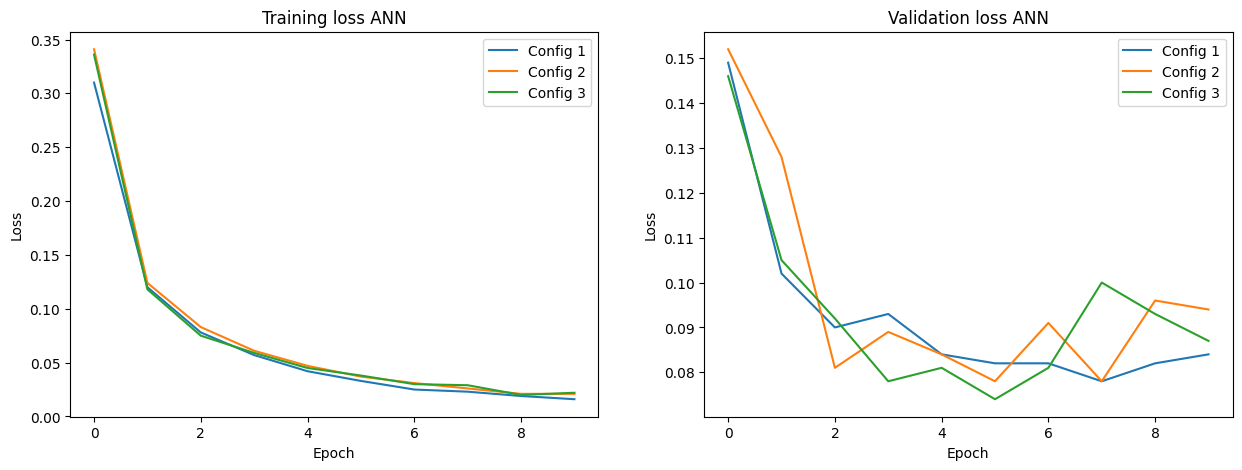

In [35]:
plotTlVl(tlANN1, tlANN2, tlANN3, vlANN1, vlANN2, vlANN3, 'ANN')

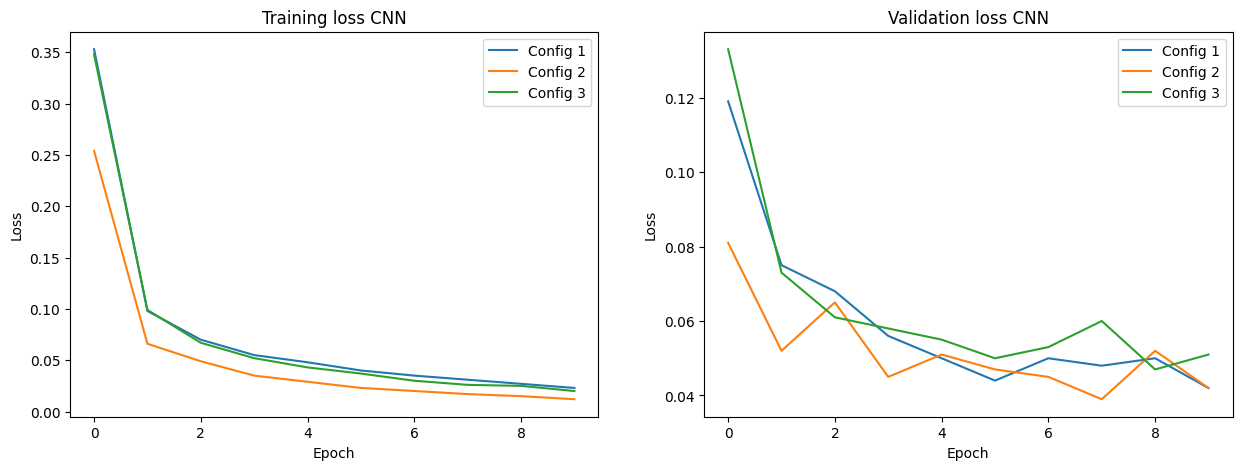

In [36]:
plotTlVl(tlCNN1, tlCNN2, tlCNN3, vlCNN1, vlCNN2, vlCNN3, 'CNN')

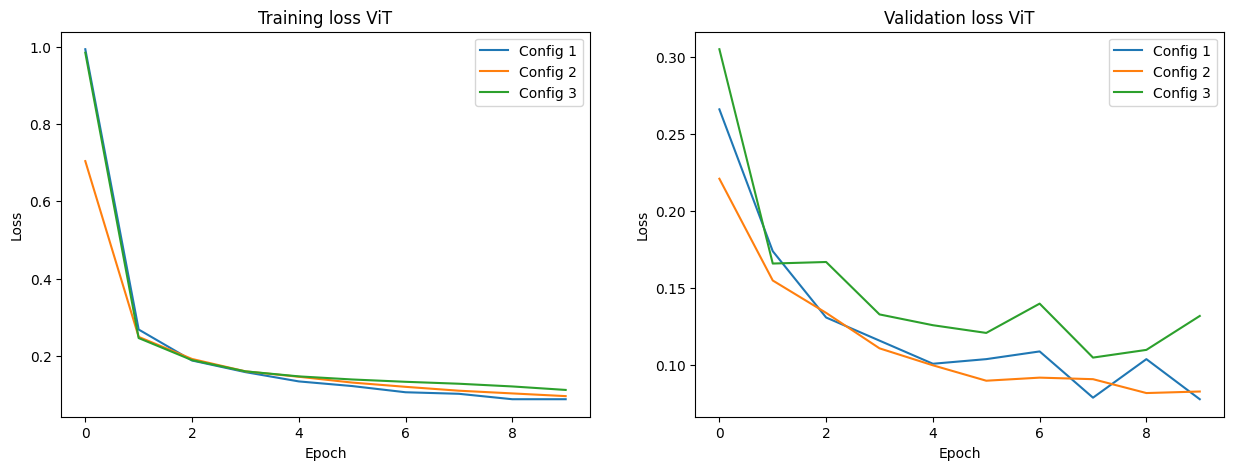

In [37]:
plotTlVl(tlViT1, tlViT2, tlViT3, vlViT1, vlViT2, vlViT3, 'ViT')

- Adam optimizer is used with a learning rate of 0.001.
- All models are trained for 10 epochs.
- The batch size is 64.
- Cross-entropy loss is used as the loss function.
- Config files are used to pass hyperparameters to the models.

## 1 (b)

ANN 
- Config1
    - Parameters : 266,610
    - Best model 
- Config2  
    - Parameters : 242,762
    - Worst model
- Config3
    - Parameters : 575,050
CNN     
- Config1
    - Parameters : 44,426
    - Worst model
- Config2
    - Parameters : 85,822
    - Best model
- Config3
    - Parameters : 51,338
               
ViT
- Config1
    - Parameters : 848,458          
- Config2
    - Parameters : 40,618
    - Best model
- Config3
    - Parameters : 1,199,626
    - Worst model
- For ViT less parameters are better. 

## 1 (c)

In [44]:
configANNbest = {
    'input_size': 784,
    'output_size': 10,
    'hidden_layers': [300, 100]
}
configANNworst = {
    'input_size': 784,
    'output_size': 10,
    'hidden_layers': [256, 128, 64]
}
configCNNbest = {
    'filetrs': [16, 32],
    'kernel_sizes': [5, 5],
    'fc': [120, 84]
}
configCNNworst = {
    'filetrs': [6, 16],
    'kernel_sizes': [5, 5],
    'fc': [120, 84]
}
configViTbest = {
    'img_size': 28,
    'patch_size': 7,
    'num_classes': 10,
    'dim': 32,
    'depth': 3,
    'heads': 4,
    'mlp_dim': 128,
    'channels': 1,
}
configViTworst = {
    'img_size': 28,
    'patch_size': 7,
    'num_classes': 10,
    'dim': 128,
    'depth': 6,
    'heads': 8,
    'mlp_dim': 512,
    'channels': 1,
}

In [65]:
def getLatentRepANN():
    best_model = ANN(**configANNbest).to(device)
    best_model.load_state_dict(torch.load(f"{os.getcwd()}/ANNconfig1/best_model.pth"))
    worst_model = ANN(**configANNworst).to(device)
    worst_model.load_state_dict(torch.load(f"{os.getcwd()}/ANNconfig2/best_model.pth"))

    best_model.eval()
    worst_model.eval()
    best_latent_rep = []
    worst_latent_rep = []
    labels_list = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            best_latent_rep.append(best_model(images.view(images.shape[0], -1)).cpu().numpy())
            worst_latent_rep.append(worst_model(images.view(images.shape[0], -1)).cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    best_latent_rep = np.concatenate(best_latent_rep)
    worst_latent_rep = np.concatenate(worst_latent_rep)
    labels_list = np.concatenate(labels_list)
    return best_latent_rep, worst_latent_rep, labels_list

In [66]:
def getLatentCNN():
    best_model = CNN(**configCNNbest).to(device)
    best_model.load_state_dict(torch.load(f"{os.getcwd()}/CNNconfig2/best_model.pth"))
    worst_model = CNN(**configCNNworst).to(device)
    worst_model.load_state_dict(torch.load(f"{os.getcwd()}/CNNconfig1/best_model.pth"))

    best_model.eval()
    worst_model.eval()
    best_latent_rep = []
    worst_latent_rep = []
    labels_list = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            # get latent representation
            for i, layer in enumerate(best_model.conv):
                if i == 0:
                    out = F.relu(layer(images))
                else:
                    out = F.relu(layer(out))
                out = best_model.pool(out)
            out = out.view(-1, best_model.input_size)
            best_latent_rep.append(out.cpu().numpy())
            # get latent representation
            for i, layer in enumerate(worst_model.conv):
                if i == 0:
                    out = F.relu(layer(images))
                else:
                    out = F.relu(layer(out))
                out = worst_model.pool(out)
            out = out.view(-1, worst_model.input_size)
            worst_latent_rep.append(out.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    best_latent_rep = np.concatenate(best_latent_rep)
    worst_latent_rep = np.concatenate(worst_latent_rep)
    labels_list = np.concatenate(labels_list)
    return best_latent_rep, worst_latent_rep, labels_list
        

In [67]:
def getLatentViT():
    best_model = ViTMy2(**configViTbest).to(device)
    best_model.load_state_dict(torch.load(f"{os.getcwd()}/ViTconfig2/best_model.pth"))
    worst_model = ViTMy2(**configViTworst).to(device)
    worst_model.load_state_dict(torch.load(f"{os.getcwd()}/ViTconfig3/best_model.pth"))

    best_model.eval()
    worst_model.eval()
    best_latent_rep = []
    worst_latent_rep = []
    labels_list = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            p = best_model.patch_size
            out = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)(images)
            out = best_model.patch_embedding(out)
            cls_tokens = best_model.cls_token.repeat(out.shape[0], 1, 1)
            out = torch.cat((cls_tokens, out), dim=1)
            out += best_model.pos_embedding
            out = best_model.encoder(out)
            out = out[:, 0]
            best_latent_rep.append(out.cpu().numpy())
            # get latent representation
            p = worst_model.patch_size
            out = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)(images)
            out = worst_model.patch_embedding(out)
            cls_tokens = worst_model.cls_token.repeat(out.shape[0], 1, 1)
            out = torch.cat((cls_tokens, out), dim=1)
            out += worst_model.pos_embedding
            out = worst_model.encoder(out)
            out = out[:, 0]
            worst_latent_rep.append(out.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    best_latent_rep = np.concatenate(best_latent_rep)
    worst_latent_rep = np.concatenate(worst_latent_rep)
    labels_list = np.concatenate(labels_list)

    return best_latent_rep, worst_latent_rep, labels_list

In [71]:
tsne = TSNE(n_components=2, random_state=seed)

def plotTSNE(latent1, latent2, labels, model_name):
    l1t = tsne.fit_transform(latent1)
    l2t = tsne.fit_transform(latent2)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for i in range(10):
        axs[0].scatter(l1t[labels == i, 0], l1t[labels == i, 1], label=f'{i}')
    axs[0].set_title(f'TSNE {model_name} best model')
    axs[0].legend()
    for i in range(10):
        axs[1].scatter(l2t[labels == i, 0], l2t[labels == i, 1], label=f'{i}')
    axs[1].set_title(f'TSNE {model_name} worst model')
    axs[1].legend()
    plt.show()
    

/tmp/ipykernel_242915/867828778.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(f"{os.getcwd()}/ANNconfig1/best_model.pth"))
/tmp/i

100%|██████████| 219/219 [00:01<00:00, 210.97it/s]


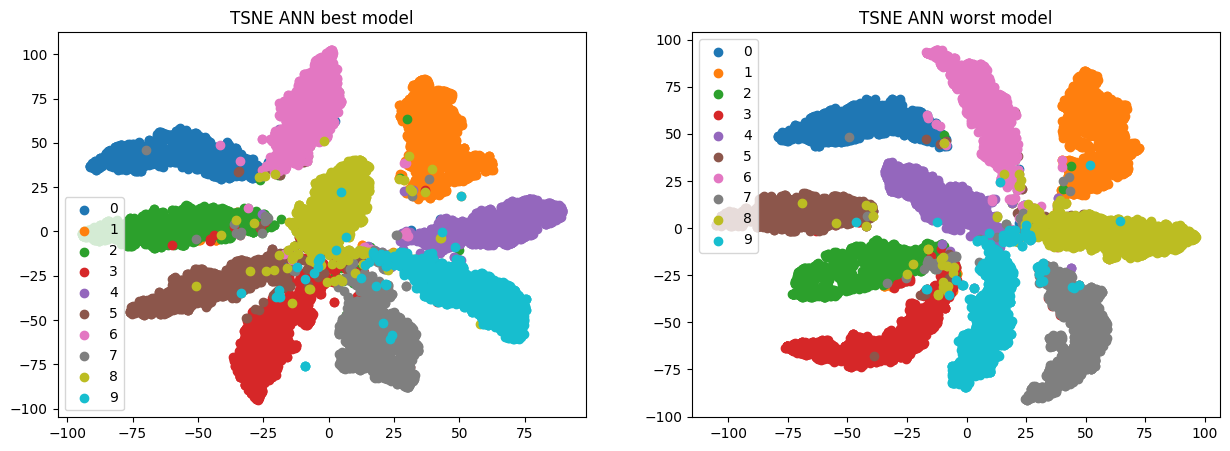

In [72]:
best_latent_repANN, worst_latent_repANN, labels_listANN = getLatentRepANN()
plotTSNE(best_latent_repANN, worst_latent_repANN, labels_listANN, 'ANN')

/tmp/ipykernel_242915/2787510876.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(f"{os.getcwd()}/CNNconfig2/best_model.pth"))
/tmp/

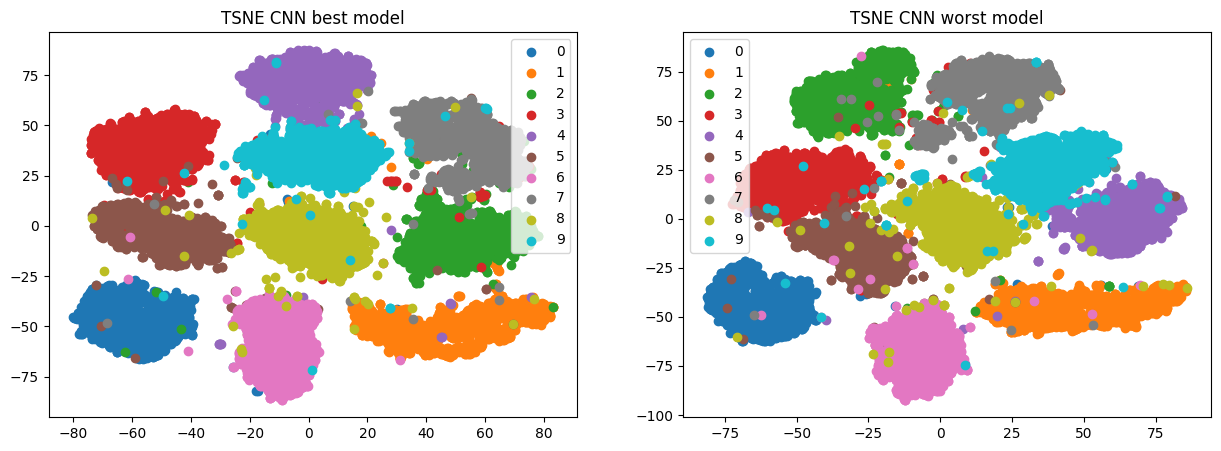

In [73]:
best_latent_repCNN, worst_latent_repCNN, labels_listCNN = getLatentCNN()
plotTSNE(best_latent_repCNN, worst_latent_repCNN, labels_listCNN, 'CNN')

/tmp/ipykernel_242915/3231318070.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(f"{os.getcwd()}/ViTconfig2/best_model.pth"))
/tmp/

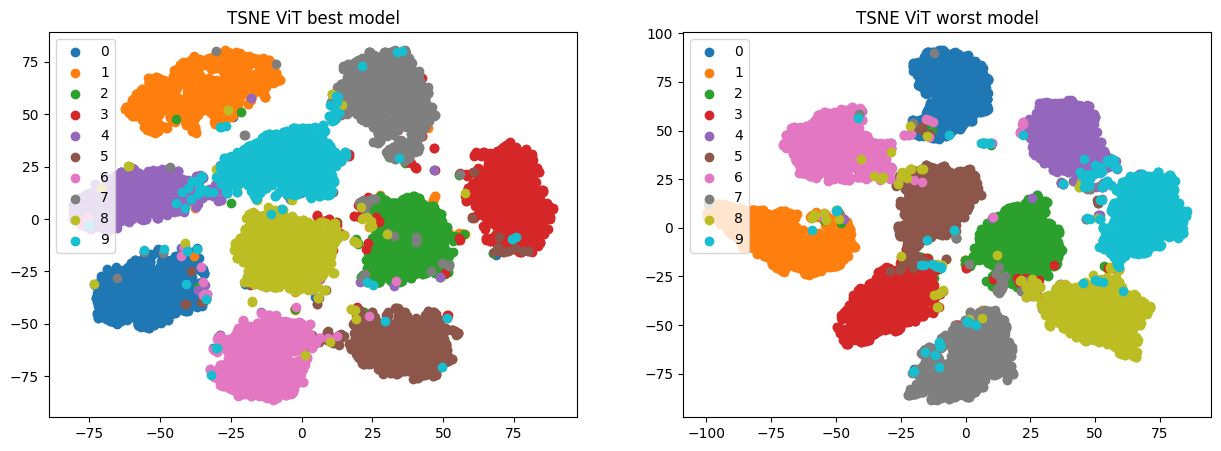

In [74]:
best_latent_repViT, worst_latent_repViT, labels_listViT = getLatentViT()
plotTSNE(best_latent_repViT, worst_latent_repViT, labels_listViT, 'ViT')

In [63]:
# print best and worst latent representations size 
print(f"Best latent representation size ANN: {best_latent_repANN.shape}")
print(f"Worst latent representation size ANN: {worst_latent_repANN.shape}")

print(f"Best latent representation size CNN: {best_latent_repCNN.shape}")
print(f"Worst latent representation size CNN: {worst_latent_repCNN.shape}")

print(f"Best latent representation size ViT: {best_latent_repViT.shape}")
print(f"Worst latent representation size ViT: {worst_latent_repViT.shape}")

Best latent representation size ANN: (14000, 10)
Worst latent representation size ANN: (14000, 10)
Best latent representation size CNN: (14000, 512)
Worst latent representation size CNN: (14000, 256)
Best latent representation size ViT: (14000, 32)
Worst latent representation size ViT: (14000, 128)


## 1 (e)

ViT
- Config1
    - Parameters : 848,458          
- Config2
    - Parameters : 40,618
    - Best model
- Config3
    - Parameters : 1,199,626
    - Worst model
- For ViT less parameters are better.
- Performance of ViT is slightly worse than CNN and ANN, in terms of accuracy.
- MNIST images are small and simple, so CNN and ANN are more suitable for this dataset.
- ViT is more suitable for large datasets, as patches of 7x7 on 28x28 makes it difficult to learn the features.